In [4]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [5]:
useDeng = False
cameraNumber = 4
useFisheye = True

patternSize = (6, 4)
squareSize = 40
imgSize = (1200, 800)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

def construct3DPoints(patternSize, squareSize):
    X = np.zeros((patternSize[0] * patternSize[1], 3), np.float32)
    X[:, :2] = np.mgrid[0 : patternSize[0], 0 : patternSize[1]].T.reshape(-1, 2)
    X = X * squareSize
    return X


boardPoints = construct3DPoints(patternSize, squareSize)

In [6]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_mono_160fov_raw"

_webcam_calib_folder = os.path.join(
    _pth,'..', _parent_folder, "calibration",'160_fov', _calib_folder_name
)
_webcam_calib_video = os.path.join(_webcam_calib_folder, "webcam_color.msgpack")
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join(_webcam_calib_folder, "webcam_calibration.msgpack")

In [7]:
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)
_video_length = 0

for _frame in _video_data:
    _video_length += 1

_video_file.close()

print('video length, ', _video_length)

video length,  7761


In [8]:
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

chessb_corners = []
counter = 0

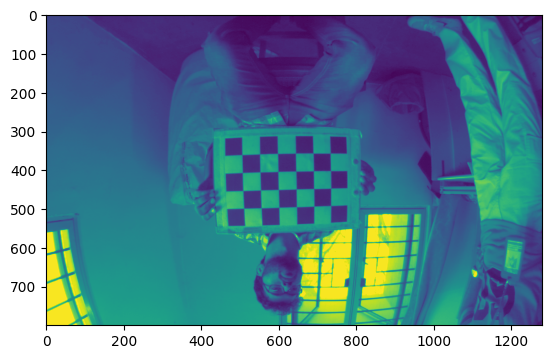

In [9]:
plt.imshow(_frame)

In [10]:
# for idx, frame in enumerate(tqdm(_video_data)):
def detectCorners(_frame):
    _frame = cv2.rotate(_frame.copy(), cv2.ROTATE_180)

    ret, corners = cv2.findChessboardCorners(_frame, patternSize)
    if ret:
        corners = cv2.cornerSubPix(
            _frame,
            corners,
            (5, 5),
            (-1, -1),
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001),
        )
    return corners
# Parallel execution with joblib
chessb_corners = []
results = Parallel(n_jobs=20, verbose=0)(
    delayed(detectCorners)(frame) for frame in tqdm(_video_data)
)
# Collect results
for result in results:
    if result is not None:
        chessb_corners.append(result)

0it [00:00, ?it/s]

In [19]:
# chessb_corners[0]

In [20]:
# Get the directory of the video file
video_dir = os.path.dirname(_video_pth)
corners_file = os.path.join(video_dir, "chessb_corners.msgpack")

with open(corners_file, "wb") as f:
    _packed_file = mp.packb(chessb_corners, default=mpn.encode)
    f.write(_packed_file)

# del(chessb_corners)

In [21]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined

In [ ]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed
# np.random.seed(9)

In [ ]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_mono_160fov_raw"

_webcam_calib_folder = os.path.join(
    _pth,'..', _parent_folder, "calibration",'160_fov', _calib_folder_name
)

_webcam_calib_video = os.path.join(_webcam_calib_folder, "webcam_color.msgpack")
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_corners_pth = os.path.join(_webcam_calib_folder, "chessb_corners.msgpack")

In [ ]:
# load data

_corners_file = open(_webcam_corners_pth, "rb")
chessb_corners = list(mp.Unpacker(_corners_file, object_hook=mpn.decode))
chessb_corners = chessb_corners[0]
chessb_corners = np.array(chessb_corners)

In [ ]:
useDeng = False
cameraNumber = 4
useFisheye = True

patternSize = (6, 4)
squareSize = 40
imgSize = (1200, 800)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def construct3DPoints(patternSize, squareSize):
    X = np.zeros((patternSize[0] * patternSize[1], 3), np.float32)
    X[:, :2] = np.mgrid[0 : patternSize[0], 0 : patternSize[1]].T.reshape(-1, 2)
    X = X * squareSize
    return X


boardPoints = construct3DPoints(patternSize, squareSize)

In [ ]:

def calibrate_single_iteration(_):
    rnd = np.random.choice(len(chessb_corners), 80)
    chessb_c = chessb_corners[rnd]
    worldPoints = []
    imagePoints = []

    for _f in chessb_c:
        imagePoints.append(_f)
        worldPoints.append(boardPoints)

    if useFisheye:
        flagsCalib = (
            cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
            + cv2.fisheye.CALIB_FIX_SKEW
            + cv2.fisheye.CALIB_CHECK_COND
        )
        calibrateCriteria = (
            cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
            30,
            1e-12,
        )
        ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(
            np.expand_dims(np.asarray(worldPoints), -2),
            imagePoints,
            imgSize,
            None,
            None,
            flags=flagsCalib,
            criteria=calibrateCriteria,
        )
    else:
        flagsCalib = cv2.CALIB_RATIONAL_MODEL
        ret, cameraMatrix, k, R, t = cv2.calibrateCamera(
            worldPoints, imagePoints, imgSize, None, None, flags=flagsCalib
        )

    # print(worldPoints)
    return {"ReError": ret, "mat": cameraMatrix, "dist": k, "rvec": R, "tvec": t, 'rnd':rnd}


# Parallel execution with joblib
my_dict = {"ReError": [], "mat": [], "dist": [], "rvec": [], "tvec": [], 'rnd_value':[]}

results = Parallel(n_jobs=20, verbose=0)(
    delayed(calibrate_single_iteration)(_) for _ in tqdm(range(2000))
)
# Collect results
for result in results:
    my_dict["ReError"].append(result["ReError"])
    my_dict["mat"].append(result["mat"])
    my_dict["dist"].append(result["dist"])
    my_dict["rvec"].append(result["rvec"])
    my_dict["tvec"].append(result["tvec"])
    my_dict['rnd_value'].append(result['rnd'])


# calibrate_single_iteration(10)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# video_dir = os.path.dirname(_video_pth)
calibration_file = os.path.join(_webcam_calib_folder, "calibration_data_2000.msgpack")

with open(calibration_file, "wb") as f:
    _packed_file = mp.packb(my_dict, default=mpn.encode)
    f.write(_packed_file)

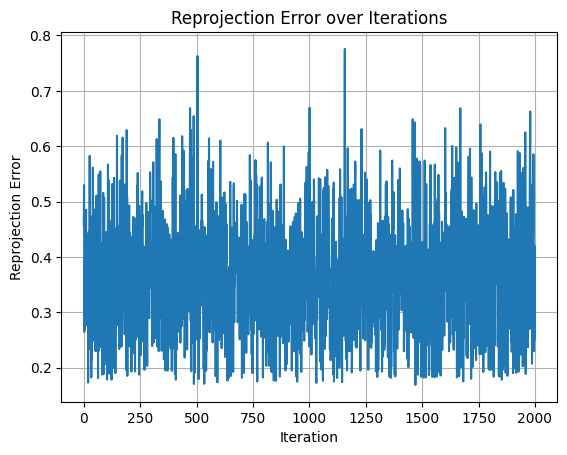

In [ ]:
plt.plot(my_dict['ReError'])
plt.xlabel('Iteration')
plt.ylabel('Reprojection Error')
plt.title('Reprojection Error over Iterations')
plt.grid()

In [ ]:
min_rerr_idx = np.argmin(my_dict['ReError'])
print('Minimum Reprojection Error:', my_dict['ReError'][min_rerr_idx], ' at index ', min_rerr_idx)

Minimum Reprojection Error: 0.16868872018120676  at index  1470


In [ ]:
rerr = my_dict['ReError'][min_rerr_idx]
camera_mat = my_dict['mat'][min_rerr_idx]
camera_dist = my_dict['dist'][min_rerr_idx]

In [ ]:
print(rerr, camera_mat, camera_dist)

0.16868872018120676 [[580.13933706   0.         654.39107434]
 [  0.         584.41422111 335.34225922]
 [  0.           0.           1.        ]] [[-0.03452381]
 [ 0.01333757]
 [-0.02537374]
 [ 0.01082018]]


Translation Vector Standard Deviation: [194.39467018 112.03707217  77.65797648]


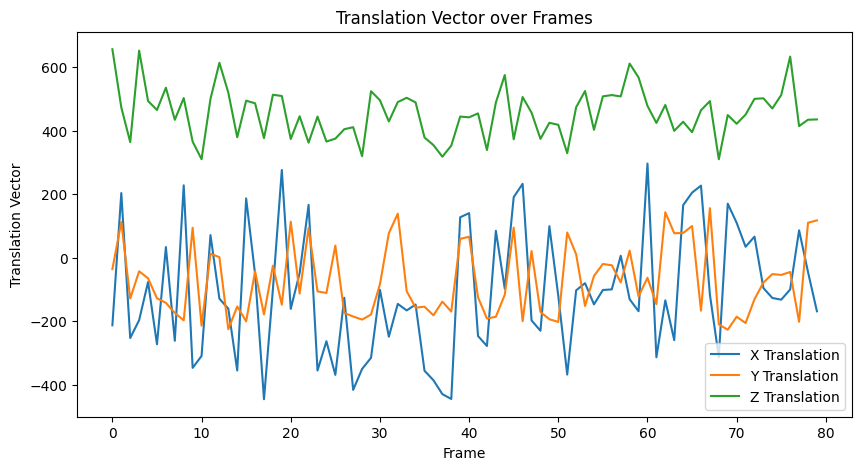

In [ ]:
# plot the translation vector
tvec = my_dict['tvec'][0]
tvec = np.array(tvec).T[0]
plt.figure(figsize=(10, 5))
plt.plot(tvec[0], label='X Translation')
plt.plot(tvec[1], label='Y Translation')
plt.plot(tvec[2], label='Z Translation')
plt.xlabel('Frame')
plt.ylabel('Translation Vector')
plt.title('Translation Vector over Frames')
plt.legend()

# standard deviation of the translation vector
tvec_std = np.std(tvec, axis=1)
print('Translation Vector Standard Deviation:', tvec_std)

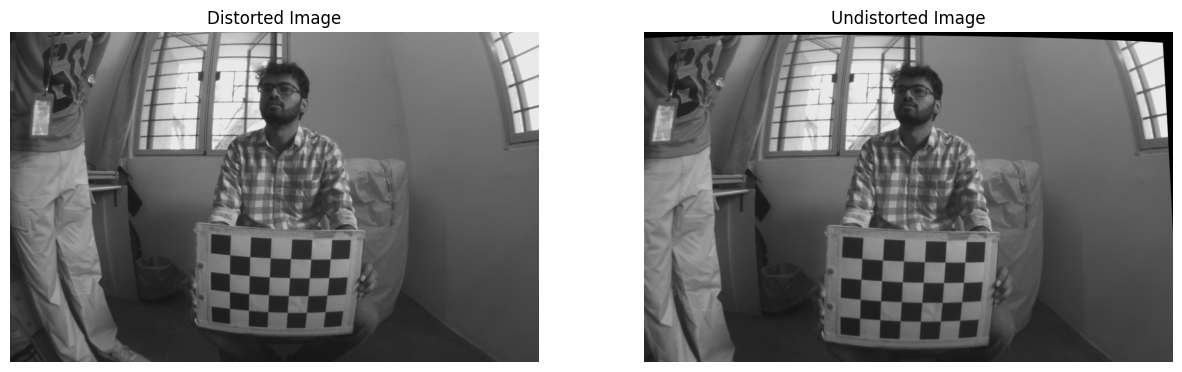

In [ ]:
# show distorted and undistorted images
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)
for idx, frame in enumerate(_video_data):
    # frame = cv2.flip(frame, 0)
    frame = cv2.rotate(frame, cv2.ROTATE_180)
    frame_undistorted = cv2.undistort(frame, camera_mat, camera_dist)
    # create a subplot with 2 images and break at first image and plot chessboard corners
    
    if idx == 0:
        plt.figure(figsize=(15, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title('Distorted Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(frame_undistorted, cv2.COLOR_BGR2RGB))
        plt.title('Undistorted Image')
        plt.axis('off')
        plt.show()
        break

In [ ]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined

# Analysis by using a second video

In [ ]:
import cv2
from cv2 import aruco
import numpy as np
import msgpack as mp
import msgpack_numpy as mpn
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [ ]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_mono_160fov_raw"
_recording_folder_name = "randomxyz_t0"

_webcam_calib_folder = os.path.join(
    _pth,'..', _parent_folder, "calibration",'160_fov', _calib_folder_name
)

_reference_recording_folder = os.path.join(
    _pth, '..', _parent_folder, "recordings",'160_fov','3marker_complete_data', _recording_folder_name
)
_reference_file = os.path.join(_reference_recording_folder, "webcam_color.msgpack")

# for loading 9000 values
_calibration_data = os.path.join(_webcam_calib_folder, 'calibration_data_1000.msgpack')

# for loading just 100 points
_calibration_data = os.path.join(_webcam_calib_folder, 'calibration_data_100.msgpack')

_timestamp_file = os.path.join(_reference_recording_folder, "webcam_timestamp.msgpack")
with open(_timestamp_file, "rb") as f:
    _metadata = list(mp.Unpacker(f, object_hook=mpn.decode))
    _timestamp = np.array(_metadata)[:,1]
    _sync_pulse = np.array(_metadata)[:,0]
    


In [ ]:
_ref_video_length = 0

for _ in mp.Unpacker(open(_reference_file, "rb"), object_hook=mpn.decode):
    _ref_video_length += 1

print('video length, ', _ref_video_length)

video length,  2861


In [ ]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36h11)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients = np.zeros((5, 1))
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs, tvecs = [], []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            flags=cv2.SOLVEPNP_ITERATIVE,
        )
        if r is not None and t is not None:
            rvecs.append(r.reshape(1, 3).tolist())
            tvecs.append(t.reshape(1, 3).tolist())
        else:
            rvecs.append(np.array([[np.nan, np.nan, np.nan]]).tolist())
            tvecs.append(np.array([[np.nan, np.nan, np.nan]]).tolist())
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

## load clalibration data

In [ ]:
_calib_data = list(mp.Unpacker(open(_calibration_data, "rb"), object_hook=mpn.decode))

In [ ]:
len(_calib_data[0]['ReError'])

2000

In [ ]:
# selecting random 50 frames
np.random.seed(9)
_random_reference_frames_idx = np.random.choice(_ref_video_length, 300)

_ref_data = mp.Unpacker(open(_reference_file, "rb"), object_hook=mpn.decode)

# _ref_frames = []

ar_total_results = {'calib_idx':[], 'ar_data':[]}
ar_results = {'corners': [], 'ids': [], 'rejected': []}
vector_std = {'v1std':[], 'v2std':[], 'v3std':[], 'sum':[], 
              'r1std':[], 'r2std':[], 'r3std':[], 'r_sum':[]}

for idx, _frame in tqdm(enumerate(_ref_data)):
    # if idx in _random_reference_frames_idx:

        # _frame = cv2.rotate(_frame, cv2.ROTATE_180)
    _frame = cv2.flip(_frame, 1)
    res = detector.detectMarkers(_frame,)
    
    res = detector.refineDetectedMarkers(_frame, board, res[0], res[1], res[2])
    ar_results['corners'].append(res[0])
    ar_results['ids'].append(res[1])
    ar_results['rejected'].append(res[2])

0it [00:00, ?it/s]

In [ ]:

# Alternative approach using a more flexible data structure
def process_aruco_detections(ar_results, target_ids=[12, 14, 20]):
    """
    Process ArUco detection results, handling missing IDs gracefully.
    
    Args:
        ar_results: Dictionary containing 'ids', 'corners', 'rvecs', 'tvecs'
        target_ids: List of marker IDs we want to track
    
    Returns:
        Dictionary with transformed translation vectors for each target ID
    """
    transformed_tvec = {str(tid): [] for tid in target_ids}
    initial_rmat = None
    initial_tvec = None
    
    for frame_idx in range(len(ar_results['ids'])):
        if ar_results['ids'][frame_idx] is None or len(ar_results['ids'][frame_idx]) == 0:
            # No markers detected in this frame
            for target_id in target_ids:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
            continue
            
        # Sort detections by ID for consistency
        sorted_indices = np.argsort(ar_results['ids'][frame_idx])
        sorted_ids = ar_results['ids'][frame_idx][sorted_indices]
        sorted_rvecs = ar_results['rvecs'][frame_idx][sorted_indices]
        sorted_tvecs = ar_results['tvecs'][frame_idx][sorted_indices]
        
        # Initialize reference frame from first detection
        if initial_rmat is None:
            initial_rmat = cv2.Rodrigues(sorted_rvecs[0])[0]
            initial_tvec = sorted_tvecs[0]
            # For the first frame, just fill with NaN (or zeros if preferred)
            for target_id in target_ids:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
            continue
        
        # Transform all detected markers to reference frame
        temp_vec = sorted_tvecs.reshape(-1, 3).T - initial_tvec.reshape(-1, 3).T
        transformed_positions = (initial_rmat.T @ temp_vec).T
        
        # Create mapping from ID to transformed position
        id_to_position = dict(zip(sorted_ids, transformed_positions))
        
        # Append results for each target ID
        for target_id in target_ids:
            if target_id in id_to_position:
                transformed_tvec[str(target_id)].append(id_to_position[target_id])
            else:
                transformed_tvec[str(target_id)].append(np.full(3, np.nan))
    
    return transformed_tvec

# Usage example:
# transformed_tvec = process_aruco_detections(ar_results, target_ids=[12, 14, 20])

# For handling NaN values later in your analysis:
def clean_transformed_data(transformed_tvec):
    """Remove NaN entries and return valid data points with their indices."""
    cleaned_data = {}
    for marker_id, positions in transformed_tvec.items():
        positions_array = np.array(positions)
        # Find rows where all values are not NaN
        valid_mask = ~np.isnan(positions_array).all(axis=1)
        cleaned_data[marker_id] = {
            'positions': positions_array[valid_mask],
            'frame_indices': np.where(valid_mask)[0]
        }
    return cleaned_data

def undistort_aruco_corners_fisheye(corners, camera_matrix, dist_coeffs):
    """
    Undistort ArUco corners using fisheye camera model.
    
    Args:
        corners: List of corner arrays from ArUco detection
        camera_matrix: Original fisheye camera matrix
        dist_coeffs: Fisheye distortion coefficients
    
    Returns:
        undistorted_corners: List of undistorted corner arrays
    """
    if corners is None or len(corners) == 0:
        return corners
    
    undistorted_corners = []
    
    for corner_set in corners:
        # Reshape corners to the format expected by undistortPoints
        corner_points = corner_set.reshape(-1, 1, 2).astype(np.float32)
        
        # Undistort using fisheye model
        undistorted_points = cv2.fisheye.undistortPoints(
            corner_points,
            camera_matrix,
            dist_coeffs,
            P=camera_matrix
        )
        
        # Reshape back to original format
        undistorted_corner_set = undistorted_points.reshape(corner_set.shape)
        undistorted_corners.append(undistorted_corner_set)
    
    return undistorted_corners

In [ ]:
import numpy as np
from scipy import stats
from tqdm import tqdm
import cv2
from joblib import Parallel, delayed



# Define filtering functions outside the loop
def filter_90th_percentile_zscore(data, z_threshold=1.28):  # z=1.28 corresponds to ~90th percentile
    """Filter data to keep only values within 90th percentile using z-score"""
    data = np.array(data)
    data_clean = data[~np.isnan(data)]  # Remove NaN values
    if len(data_clean) == 0:
        return data_clean
    
    z_scores = np.abs(stats.zscore(data_clean))
    return data_clean[z_scores <= z_threshold]

def filter_90th_percentile_direct(data):
    """Filter data to keep only values up to 90th percentile"""
    data = np.array(data)
    data_clean = data[~np.isnan(data)]  # Remove NaN values
    if len(data_clean) == 0:
        return data_clean
    
    percentile_90 = np.percentile(data_clean, 90)
    return data_clean[data_clean <= percentile_90]

def process_single_calibration(idx, cal, ar_results):
    """Process a single calibration matrix"""
    mat = cal[0]
    dist = cal[1]
    
    # map1, map2 = cv2.fisheye.initUndistortRectifyMap(
    #     mat, dist, np.eye(3), mat, (1200, 800), cv2.CV_16SC2
    # )
    # new_matrix = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(
    #     mat, dist, (1200, 800), None, None, cv2.CALIB_USE_INTRINSIC_GUESS
    # )

    _ar_results = {'corners': [], 'ids': [], 'rvecs': [], 'tvecs': []}

    for _res in zip(ar_results['ids'], ar_results['corners']):
        corners = undistort_aruco_corners_fisheye(_res[1], mat, dist)
        _ar_results['corners'].append(corners)
        _ar_results['ids'].append(np.array(_res[0]).T.reshape(-1))
        
        if _res[0] is not None and len(_res[0]) > 0:
            rvecs, tvecs = estimate_pose_single_markers(
                corners, markerLength, mat, dist
            )
            _ar_results['rvecs'].append(rvecs)
            _ar_results['tvecs'].append(tvecs)

        transformed_tvec = process_aruco_detections(_ar_results, target_ids=[12, 14, 20])
        transformed_tvec = clean_transformed_data(transformed_tvec)
        

    return {
        'calib_idx': idx,
        'ar_data': transformed_tvec,
    }

# process_single_calibration(0, (_calib_data[0]['mat'][0], _calib_data[0]['dist'][0]), ar_results)
# Parallel processing of calibration matrices
print("Processing calibration matrices in parallel...")
calibration_data = list(zip(_calib_data[0]['mat'], _calib_data[0]['dist']))

# Use joblib to parallelize calibration processing
# n_jobs=-1 uses all available cores, you can set specific number like n_jobs=4
results = Parallel(n_jobs=8, verbose=1)(
    delayed(process_single_calibration)(idx, cal, ar_results) 
    for idx, cal in enumerate(tqdm(calibration_data, desc="Preparing calibration jobs"))
)

# Collect results
for result in results:
    ar_total_results['calib_idx'].append(result['calib_idx'])
    ar_total_results['ar_data'].append(result['ar_data'])

Processing calibration matrices in parallel...


Preparing calibration jobs:   1%|          | 16/2000 [00:47<1:38:00,  2.96s/it]

In [22]:
calibration_data = list(zip(_calib_data[0]['mat'], _calib_data[0]['dist']))

calibration_data

NameError: name '_calib_data' is not defined

In [ ]:
_optimization_file = os.path.join(_webcam_calib_folder, "optimization_file_100_mocap.msgpack")

with open(_optimization_file, "wb") as f:
    _packed_file = mp.packb([ar_total_results, vector_std], default=mpn.encode)
    f.write(_packed_file)

In [ ]:
_sync_pulse = np.array(_sync_pulse).astype(np.int8)
_start_pulse = 0
_end_pulse = 0
for idx, _s in enumerate(_sync_pulse):
    if _s:
        _start_pulse = idx
        break
for idx, _s in enumerate(_sync_pulse[_start_pulse:]):
    if _s == 0:
        _end_pulse = idx
        break

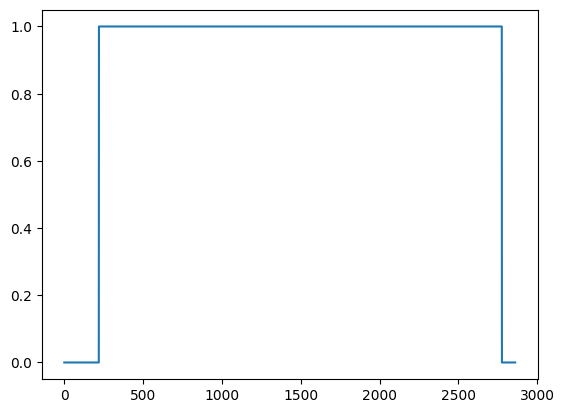

In [ ]:
plt.plot(_sync_pulse)

In [ ]:

import sys
sys.path.insert(1, os.path.dirname(os.getcwd()))
from pd_support import *


_movement_data_path = _reference_recording_folder
_folder_name = _recording_folder_name
_mocap_pth = os.path.join(os.path.dirname(_movement_data_path), _folder_name,f"{_folder_name}.csv")

mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
mocap_df = add_datetime_col(mocap_df, st_time, 'seconds')


e:\CMC\pyprojects\programs_rpi\rpi_python\notebooks\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [ ]:
_timestamp[_start_pulse]

np.str_('2025-08-02 09:00:57.216597')

In [ ]:
_time_offset = datetime.strptime(str(_timestamp[_start_pulse]), "%Y-%m-%d %H:%M:%S.%f") - mocap_df['time'][0]

rb_quat = mocap_df[['rb_ang_x', 'rb_ang_y', 'rb_ang_z', 'rb_ang_w']].values
rb_pos = mocap_df[['rb_pos_x', 'rb_pos_y', 'rb_pos_z']].values
from scipy.spatial.transform import Rotation as R
rb_matrix = R.from_quat(rb_quat[0]).as_matrix()
transformed_rb_pos = (rb_matrix.T @ (rb_pos.T - rb_pos[0].reshape(3,1))).T
rotation_correction = R.from_euler('xyz', [90, 0, 0], degrees=True).as_matrix()
transformed_rb_pos = (rotation_correction.T @ transformed_rb_pos.T).T

In [ ]:
import pandas as pd
from scipy.interpolate import interp1d
error_dict = {'max_x':[], 'max_y':[], 'max_z':[], 'mean_x':[], 'mean_y':[], 'mean_z':[],
              'std_x':[], 'std_y':[], 'std_z':[], 'total_error':[]}

for _i in range(len(ar_total_results['ar_data'])):
    data = ar_total_results['ar_data'][_i]
    df = pd.DataFrame(data['12']['positions'], columns=['x', 'y', 'z'])
    df['time'] = pd.to_datetime(_timestamp[1:])

    df = df[_start_pulse:_end_pulse].reset_index(drop=True)
    df['time'] = df['time'] - _time_offset
    
    _cols = ['x', 'y', 'z']
    _ar_df = pd.DataFrame()
    _ar_df['time'] = mocap_df['time']
    for col in _cols:
        _interp_func = interp1d(
            df['time'].astype(np.int64), 
            df[col], 
            bounds_error=False, 
            fill_value='extrapolate'
        )
        _ar_df[col] = _interp_func(mocap_df['time'].astype(np.int64))

    _ar_values = _ar_df[_cols].values
    diff = _ar_values - transformed_rb_pos
    
    error_dict['max_x'].append(np.nanmax(np.abs(diff[:,0])))
    error_dict['max_y'].append(np.nanmax(np.abs(diff[:,1])))
    error_dict['max_z'].append(np.nanmax(np.abs(diff[:,2])))
    error_dict['mean_x'].append(np.nanmean(diff[:,0]))
    error_dict['mean_y'].append(np.nanmean(diff[:,1]))
    error_dict['mean_z'].append(np.nanmean(diff[:,2]))
    error_dict['std_x'].append(np.nanstd(diff[:,0]))
    error_dict['std_y'].append(np.nanstd(diff[:,1]))
    error_dict['std_z'].append(np.nanstd(diff[:,2]))
    error_dict['total_error'].append(np.nansum(np.abs(diff)))
    
    

    # interpolate both to same time frames
    

# Interpolation

In [ ]:
np.argmin(error_dict['total_error'])

np.int64(22)

In [ ]:
transformed_rb_pos

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.64506876e-06, -1.99678140e-05, -2.46687898e-05],
       [ 9.94714468e-06, -2.60637220e-05, -6.72735959e-05],
       ...,
       [-5.48854228e-02,  8.88203169e-03, -4.88852722e-02],
       [-5.48335291e-02,  8.72267571e-03, -4.89716418e-02],
       [-5.47994072e-02,  8.67494671e-03, -4.90786167e-02]])

In [ ]:
mocap_df

,frame,seconds,rb_ang_x,rb_ang_y,rb_ang_z,rb_ang_w,rb_pos_x,rb_pos_y,rb_pos_z,rb_pos_err,...,m7_x,m7_y,m7_z,m8_x,m8_y,m8_z,m9_x,m9_y,m9_z,time
0,0,0.00,0.637569,0.058945,0.069006,-0.765029,-0.115329,0.775280,-0.320416,0.000633,...,-0.047947,0.830068,-0.280509,-0.153074,0.773639,-0.334443,-0.205294,0.826955,-0.306020,2025-08-02 09:00:53.580
1,1,0.01,0.637680,0.058953,0.069008,-0.764936,-0.115333,0.775265,-0.320445,0.000617,...,-0.047931,0.830055,-0.280531,-0.153124,0.773537,-0.334423,-0.205284,0.826958,-0.306045,2025-08-02 09:00:53.590
2,2,0.02,0.638113,0.058676,0.068742,-0.764620,-0.115307,0.775266,-0.320484,0.000622,...,-0.047921,0.830054,-0.280557,-0.153102,0.773486,-0.334409,-0.205276,0.826985,-0.306086,2025-08-02 09:00:53.600
3,3,0.03,0.638301,0.058634,0.068846,-0.764457,-0.115297,0.775262,-0.320517,0.000623,...,-0.047922,0.830037,-0.280592,-0.153093,0.773486,-0.334418,-0.205271,0.826970,-0.306125,2025-08-02 09:00:53.610
4,4,0.04,0.638028,0.058801,0.069229,-0.764637,-0.115318,0.775209,-0.320557,0.000698,...,-0.048216,0.829282,-0.280572,-0.153024,0.773611,-0.334499,-0.205253,0.826971,-0.306162,2025-08-02 09:00:53.620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540,2540,25.40,0.662784,0.049227,0.052268,-0.745361,-0.160615,0.794445,-0.375653,0.000836,...,-0.092155,0.851727,-0.341541,-0.198876,0.791616,-0.387943,-0.250574,0.846570,-0.361275,2025-08-02 09:01:18.980
2541,2541,25.41,0.662951,0.049297,0.052578,-0.745185,-0.160559,0.794393,-0.375799,0.000822,...,-0.092098,0.851639,-0.341627,-0.198834,0.791593,-0.388046,-0.250482,0.846496,-0.361397,2025-08-02 09:01:18.990
2542,2542,25.42,0.663094,0.049429,0.052656,-0.745044,-0.160494,0.794363,-0.375887,0.000872,...,-0.092053,0.851611,-0.341715,-0.198726,0.791642,-0.388268,-0.250406,0.846525,-0.361573,2025-08-02 09:01:19.000
2543,2543,25.43,0.663754,0.049358,0.052727,-0.744455,-0.160427,0.794220,-0.375990,0.000875,...,-0.092031,0.851580,-0.341803,-0.198669,0.791475,-0.388339,-0.250333,0.846588,-0.361766,2025-08-02 09:01:19.010


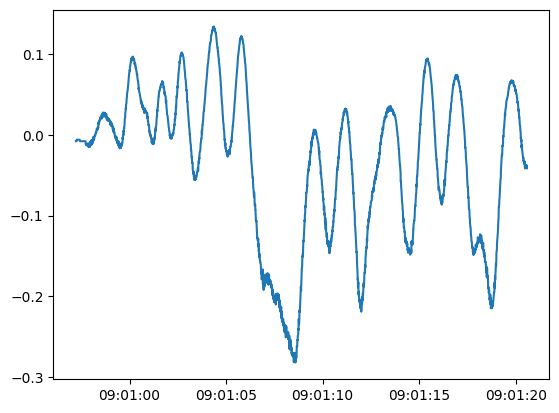

In [ ]:
plt.plot(df['time'], df['z'])

In [ ]:
_vector_std_ul = vector_std['sum'] / np.linalg.norm(vector_std['sum'])
_r_std_ul = vector_std['r_sum'] / np.linalg.norm(vector_std['r_sum'])

np.argmin((_vector_std_ul + _r_std_ul))

ValueError: attempt to get argmin of an empty sequence

In [ ]:
_calib_data[0].keys()

dict_keys(['ReError', 'mat', 'dist', 'rvec', 'tvec', 'rnd_value'])

In [ ]:
np.argmin(_calib_data[0]['ReError'])

np.int64(1470)

In [ ]:
print(_calib_data[0]['mat'][10])
print(_calib_data[0]['dist'][10])

[[583.74894761   0.         655.62169261]
 [  0.         587.45257362 334.63280683]
 [  0.           0.           1.        ]]
[[-0.0454573 ]
 [ 0.04474313]
 [-0.06101144]
 [ 0.0247249 ]]


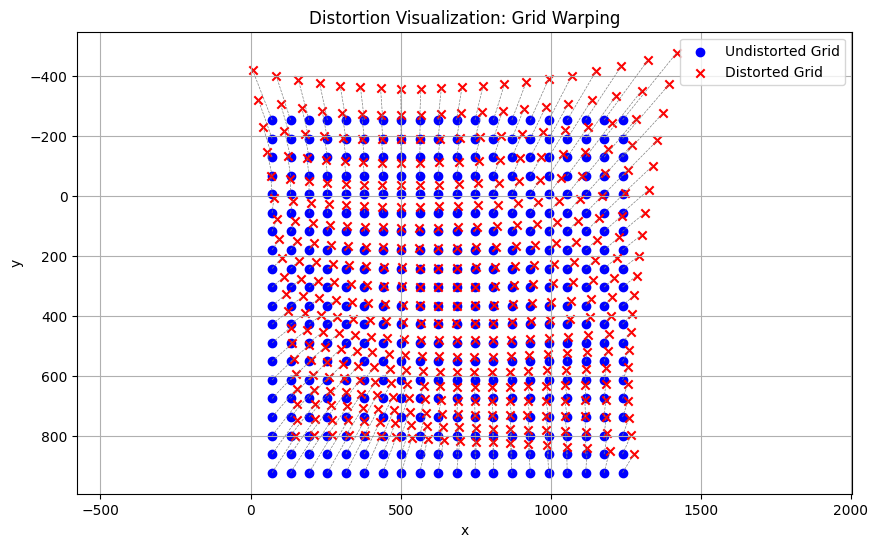

In [ ]:
# K = _calib_data[0]['mat'][np.argmin(_calib_data[0]['ReError'])]
# D = _calib_data[0]['dist'][np.argmin(_calib_data[0]['ReError'])]

K = _calib_data[0]['mat'][10]
D = _calib_data[0]['dist'][10]

# Grid size and image size
grid_size = 20
image_size = (1200, 800)

# Generate a regular grid in normalized object space (X, Y, Z)
x_vals = np.linspace(-1, 1, grid_size)
y_vals = np.linspace(-1, 1, grid_size)
xx, yy = np.meshgrid(x_vals, y_vals)
zz = np.ones_like(xx)  # Place all points at Z = 1

# Stack into 3D object points (N, 3)
object_points = np.stack([xx.ravel(), yy.ravel(), zz.ravel()], axis=-1).astype(np.float32)

# Identity rotation and zero translation (camera at origin)
rvec = np.zeros(3, dtype=np.float32)
tvec = np.zeros(3, dtype=np.float32)

# Project undistorted (ideal) and distorted image points
undistorted_points, _ = cv2.projectPoints(object_points, rvec, tvec, K, np.zeros_like(D))
distorted_points, _ = cv2.projectPoints(object_points, rvec, tvec, K, D)

undistorted_points = undistorted_points.reshape(-1, 2)
distorted_points = distorted_points.reshape(-1, 2)

# ---------- Plotting ----------
plt.figure(figsize=(10, 6))
plt.scatter(undistorted_points[:, 0], undistorted_points[:, 1], color='blue', label='Undistorted Grid')
plt.scatter(distorted_points[:, 0], distorted_points[:, 1], color='red', label='Distorted Grid', marker='x')
for pt1, pt2 in zip(undistorted_points, distorted_points):
    plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], color='gray', linestyle='--', linewidth=0.5)

plt.title('Distortion Visualization: Grid Warping')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().invert_yaxis()
plt.axis('equal')
plt.legend()
plt.grid(True)
# plt.xlim(0, image_size[0])
# plt.ylim(image_size[1], 0)
plt.show()


In [ ]:
STOP_HERE

NameError: name 'STOP_HERE' is not defined